In [1]:
import planetspy as ps
import planetspy.engines as eng
import planetspy.utils as putil
import numpy as np
import scipy as sp
import scipy.stats
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib notebook

In [2]:
%matplotlib notebook
bodies = [
    np.array([[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.371*10**6, 5.972*10**24],
              [0, 6.371*10**6 + 400*10**3, 0, 7667, 0, 0, 1, 1000],
              [6.371*10**6 + 385*10**6, 0, 0, 0, 10**3, 0, 1737.5*10**3, 7.35*10**22]
             ])
    , [["Earth", "r."], ["ISS", "b."],["Moon", "m."]]
]

recinst = putil.record()
sim = ps.Simulate(eng.PP, 100, 10, bodies, bailout = 60*60*24*30, envmod=[recinst])
sim.main_loop()
sim.steps

259200.0

<IPython.core.display.Javascript object>


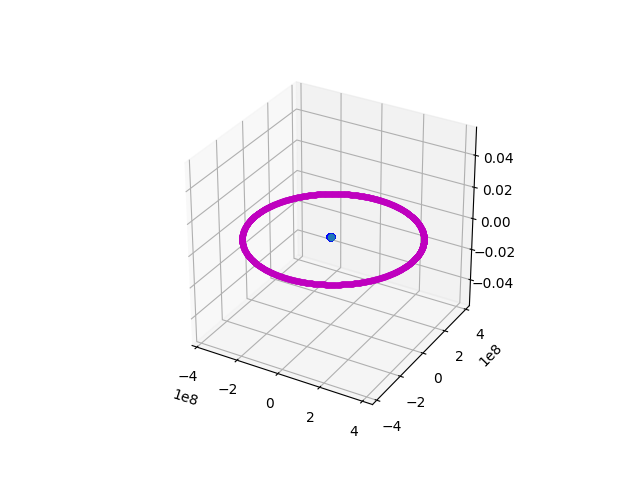

In [3]:
def plot_relative(b):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    for j in range(0,len(bodies[0])):
        ax.plot([i[j][0] - i[b][0] for i in recinst.loc], [i[j][1] - i[b][1] for i in recinst.loc], [i[j][2] - i[b][2] for i in recinst.loc], bodies[1][j][1])
    ax.scatter(0,0,0,'ro')
    ax.set_aspect("equal")
    plt.show()
    return ax
                                                                                                       
p = plot_relative(0)

<IPython.core.display.Javascript object>


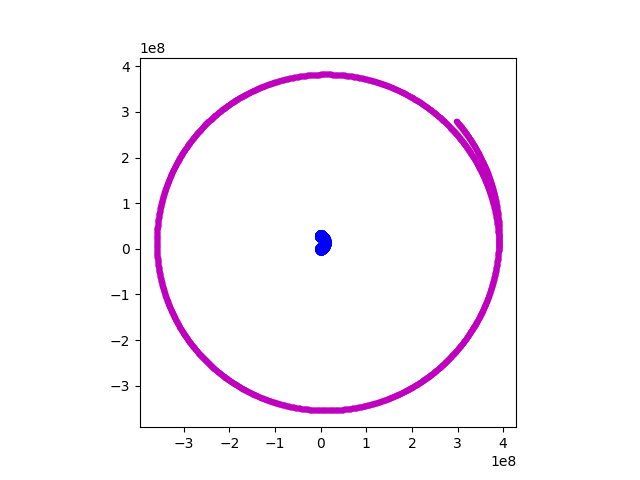

[array([[ 1.16588471e+06,  2.84464761e+07,  0.00000000e+00,
         8.13769329e+00,  3.00085360e+00,  0.00000000e+00,
         6.37100000e+06,  5.97200000e+24],
       [ 5.90992946e+06,  2.36720443e+07,  0.00000000e+00,
        -5.41312626e+03, -5.48383644e+03,  0.00000000e+00,
         1.00000000e+00,  1.00000000e+03],
       [ 2.96640884e+08,  2.80675438e+08,  0.00000000e+00,
        -6.61201419e+02,  7.56175541e+02,  0.00000000e+00,
         1.73750000e+06,  7.35000000e+22]]), [['Earth', 'r.'], ['ISS', 'b.'], ['Moon', 'm.']]]


In [4]:
fig = plt.figure()
ax = fig.add_subplot(111)
for j in range(0,len(bodies[0])):
    ax.plot([i[j][0] for i in recinst.loc], [i[j][1] for i in recinst.loc], bodies[1][j][1], linewidth = .5)

ax.set_aspect("equal")
plt.show()
print(bodies)

In [25]:
cloud = putil.cloud_gen(5.9*10**24, 384740000, 10, 30)

In [26]:
recinst = putil.record()
collinst = putil.collisions(named = False)
sim = ps.Simulate(eng.PP, 1, 30, cloud, bailout = 60*60*24*30, envmod=[recinst, collinst])
sim.main_loop()
sim.steps

86400.0

In [10]:
len(cloud[0])

15

<IPython.core.display.Javascript object>


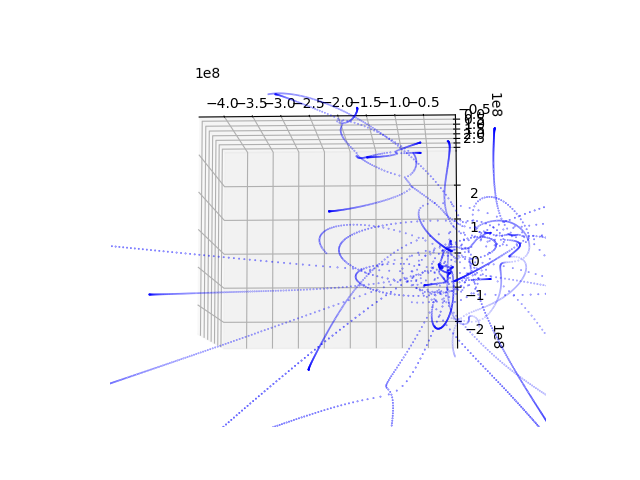

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

for i in range(len(recinst.loc)):
    if i % 300 == 0:
        ax.scatter(recinst.loc[i][::,0], recinst.loc[i][::,1], recinst.loc[i][::,2], c="b", s=0.1)
    
ax.set_aspect("equal")
plt.show()

In [32]:
smol_cloud = putil.cloud_gen(5*10**24, 4*10**8, 15 , 50)

In [33]:
recinst = putil.record()
collinst = putil.collisions(named = False)
sim = ps.Simulate(eng.PP, 1, 30, smol_cloud, bailout = 60*60*24*30, envmod=[recinst, collinst])
sim.main_loop()
sim.steps

86400.0

<IPython.core.display.Javascript object>


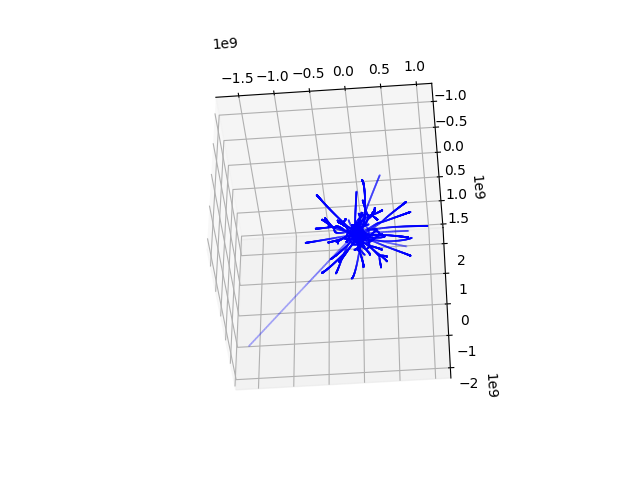

In [35]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

for i in range(len(recinst.loc)):
    if i % 300 == 0:
        ax.scatter(recinst.loc[i][::,0], recinst.loc[i][::,1], recinst.loc[i][::,2], c="b", s=0.1)
    
ax.set_aspect("equal")
plt.show()